<a href="https://colab.research.google.com/github/KyleSuchenkai/EECS598-AML/blob/master/MDP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
data_normal = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MDP_Data_set/SWaT_Dataset_Normal_v1.csv")
#data_attack = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MDP_Data_set/SWaT_Dataset_Attack_v0.csv")
column_name = ['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603',
       'Normal/Attack']
data_normal.columns = column_name
#data_attack.columns = column_name
P1_list = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']
P2_list = ['AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204','P205', 'P206']
P3_list = ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302']
P4_list = ['AIT401', 'AIT402', 'FIT401','LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401']
P5_list = ['AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503']
P6_list = ['FIT601', 'P601', 'P602', 'P603']
data_normal.Timestamp = pd.to_datetime(data_normal.Timestamp)
#data_attack.Timestamp = pd.to_datetime(data_attack.Timestamp)
data_normal = data_normal.set_index(['Timestamp'])
#data_attack = data_attack.set_index(['Timestamp'])
numericalVariable_list = ['LIT101','AIT201','AIT202','AIT203','DPIT301','FIT301','LIT301','AIT402','LIT401','AIT501','AIT502','AIT503','PIT501','PIT503','FIT601']
#Use numerical Variable to create category Variable list for convenience
categoryVariable_list = []
numericalVariable_list = ['LIT101','AIT201','AIT202','AIT203','DPIT301','FIT301','LIT301','AIT402','LIT401','AIT501','AIT502','AIT503','PIT501','PIT503','FIT601']
numericalVariable_set = set(numericalVariable_list)
for item in column_name[1:]:
    if item not in numericalVariable_set:
        categoryVariable_list.append(item)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters 
window_size = 200
step = 50
batch_size = 100
input_size = 15
output_size = 15

In [ ]:
scalar = MinMaxScaler(feature_range=(-1,1))
data = scalar.fit_transform(data_normal[numericalVariable_list])
data = data[0:50000]

# output will be [batch, seq, input_size]
gc.enable()
def sliding_window(data, window_size, step = step):
    number = data.shape[0] - window_size + 1
    train_data = np.zeros([number, window_size, data.shape[1]])
    label = np.zeros([number,data.shape[1]])
    for i in range(0, number-1, step):
        train_data[i] = data[i:i+window_size,:]
        label[i] = data[i+window_size,:]
    return train_data, label
def custom_collate_fn(batch):
    x, y = zip(*batch)
    return torch.tensor(np.stack(x), dtype = torch.float), torch.tensor(np.stack(y),dtype = torch.float)
X,y = sliding_window(data, window_size=window_size, step = 1)
del data
gc.collect()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
del X, y
gc.collect()
train_data = list(zip(X_train, y_train))
del X_train, y_train
gc.collect()
test_data = list(zip(X_test, y_test))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn = custom_collate_fn)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn = custom_collate_fn)
del train_data, test_data
gc.collect()

0

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):# output_size = input_size here
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        #input: (batch_size, seq, input_size)
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (batch_size, seq, input_size), h0: (numOfLayers, batch_size, hidden_size)
        # Forward propagate
        #out, _ = self.rnn(x, h0)  
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (batch_size, hidden_size)
        out = self.fc(out)
        # out: (batch_size, output_size)
        return out

In [ ]:
model = LSTM(input_size = input_size, hidden_size = 200, num_layers = 2, output_size = output_size).to(device)
criterion = nn.MSELoss(size_average = False, reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def test(Model, test_loader):
  with torch.no_grad():
    loss_total = 0
    for X_batch, y_batch in test_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      outputs = model(X_batch)
      loss = criterion(outputs, y_batch)
      loss_total += loss
  return loss_total
def predict(Model, test_loader):
  with torch.no_grad():
    output_list = []
    target_list = []
    for X_batch, y_batch in test_loader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      outputs = model(X_batch)
      output_list.append(outputs)
      target_list.append(y_batch)
  return output_list,target_list

In [ ]:
num_epochs = 30
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(train_loader):  
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        scheduler.zero_grad()
        loss.backward()
        scheduler.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/30], Step [100/334], Loss: 168.1053
Epoch [1/30], Step [200/334], Loss: 55.6877
Epoch [1/30], Step [300/334], Loss: 19.4383
Epoch [2/30], Step [100/334], Loss: 15.0399
Epoch [2/30], Step [200/334], Loss: 10.8684
Epoch [2/30], Step [300/334], Loss: 8.9252
Epoch [3/30], Step [100/334], Loss: 6.4199
Epoch [3/30], Step [200/334], Loss: 5.8700
Epoch [3/30], Step [300/334], Loss: 3.8994
Epoch [4/30], Step [100/334], Loss: 2.2238
Epoch [4/30], Step [200/334], Loss: 1.6317
Epoch [4/30], Step [300/334], Loss: 1.1978
Epoch [5/30], Step [100/334], Loss: 2.3084
Epoch [5/30], Step [200/334], Loss: 3.0068
Epoch [5/30], Step [300/334], Loss: 1.3139
Epoch [6/30], Step [100/334], Loss: 1.6274
Epoch [6/30], Step [200/334], Loss: 2.1265
Epoch [6/30], Step [300/334], Loss: 1.3419
Epoch [7/30], Step [100/334], Loss: 0.6494
Epoch [7/30], Step [200/334], Loss: 0.9550
Epoch [7/30], Step [300/334], Loss: 1.0938
Epoch [8/30], Step [100/334], Loss: 0.7212
Epoch [8/30], Step [200/334], Loss: 0.9046
Epoch

In [ ]:
pred, target = predict(model, test_loader)

In [ ]:
print(pred[0])

tensor([[ 0.1326, -0.0725, -0.8161,  ...,  0.9163,  0.9232, -1.0016],
        [ 0.9886, -0.3555, -0.5142,  ...,  0.9210,  0.9275, -0.9994],
        [-0.5814,  0.3494, -0.9648,  ...,  0.9416,  0.9435, -0.9941],
        ...,
        [ 0.4962,  0.0053, -0.6689,  ...,  0.9000,  0.9188, -0.9840],
        [ 0.1257, -0.3852, -0.7614,  ...,  0.9234,  0.9302, -1.0011],
        [-0.4782,  0.1586, -0.7822,  ...,  0.9162,  0.9199, -0.9988]],
       device='cuda:0')


In [ ]:
print(target[0])

tensor([[ 0.1306, -0.0691, -0.7927,  ...,  0.9163,  0.9229, -0.9999],
        [ 0.9903, -0.3425, -0.5020,  ...,  0.9213,  0.9280, -0.9999],
        [-0.5717,  0.3364, -0.9570,  ...,  0.9421,  0.9492, -0.9997],
        ...,
        [ 0.5113,  0.0138, -0.6645,  ...,  0.9123,  0.9200, -0.9999],
        [ 0.1280, -0.3856, -0.7611,  ...,  0.9252,  0.9322, -1.0000],
        [-0.4809,  0.1521, -0.7813,  ...,  0.9093,  0.9143, -0.9999]],
       device='cuda:0')


In [ ]:
test(model, test_loader)

tensor(25.5876, device='cuda:0')

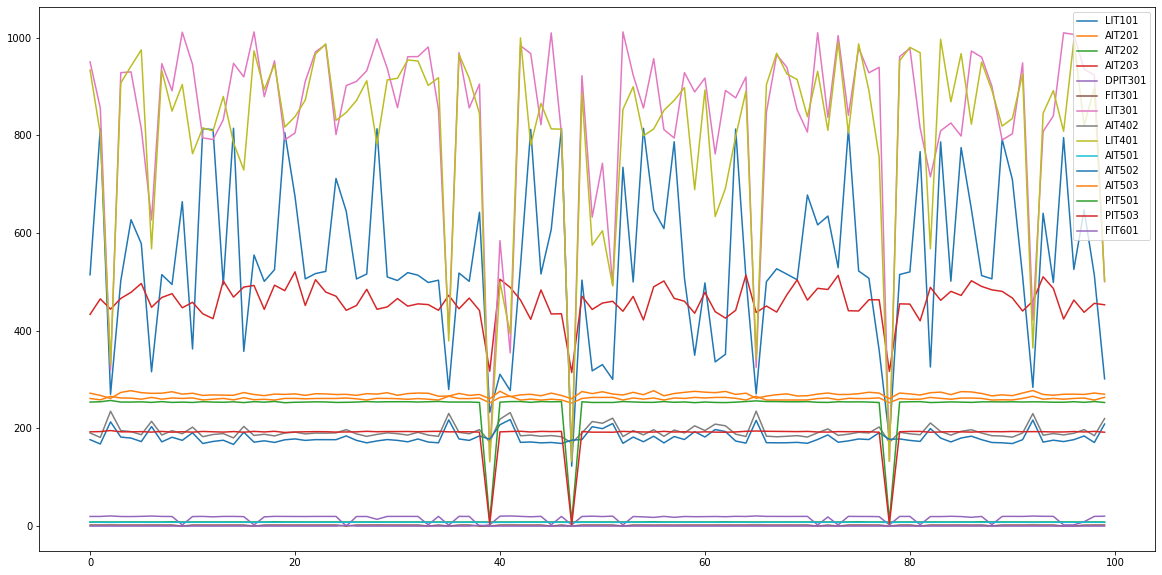

In [ ]:
dates = np.arange(100)
df1 = pd.DataFrame(scalar.inverse_transform(target[0].cpu().numpy()), index=dates, columns=numericalVariable_list)
df1
df1.plot(figsize = (20,10))

In [ ]:
df1

,LIT101,AIT201,AIT202,AIT203,DPIT301,FIT301,LIT301,AIT402,LIT401,AIT501,AIT502,AIT503,PIT501,PIT503,FIT601
0,514.603638,261.375305,8.334273,433.401703,19.725981,2.206322,950.597595,190.669098,933.914368,7.840490,177.031494,272.109711,253.941299,193.027390,0.000064
1,814.180664,258.523499,8.440336,465.265289,19.751591,2.213881,856.110718,181.517609,803.563232,7.856832,168.110703,267.591614,254.582199,193.524109,0.000064
2,269.862701,265.605011,8.274353,444.168213,20.823999,2.236428,319.429291,235.196106,330.261475,7.554666,213.458099,261.439423,257.241699,195.622894,0.000256
3,502.513824,262.304504,8.358626,466.213806,19.645941,2.210037,928.528015,195.488297,907.344299,7.859395,182.235291,273.679810,253.925308,193.011398,0.000064
4,627.376770,262.048218,8.430082,478.723389,19.524300,2.214265,930.049988,193.437592,941.873901,7.863561,180.235794,277.268616,253.957306,193.043503,0.000064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,795.417908,259.837189,8.414701,424.070679,2.378513,0.000000,1010.078064,186.721390,808.484985,7.845937,173.058212,269.898712,253.604797,192.771088,0.000064
96,525.594360,261.375305,8.340041,462.855682,2.416928,0.000000,1006.713013,190.079498,994.591064,7.840169,176.980301,270.091003,254.662308,193.588196,0.000064
97,647.278015,262.240387,8.381056,437.810791,8.893015,2.053742,935.537415,197.513504,819.674438,7.864202,184.542404,269.578308,253.428604,192.738998,0.000064
98,513.700928,258.074890,8.345809,456.088196,19.870029,2.209269,923.641357,185.106400,897.346924,7.846899,171.135590,272.430084,255.078796,193.940704,0.000000


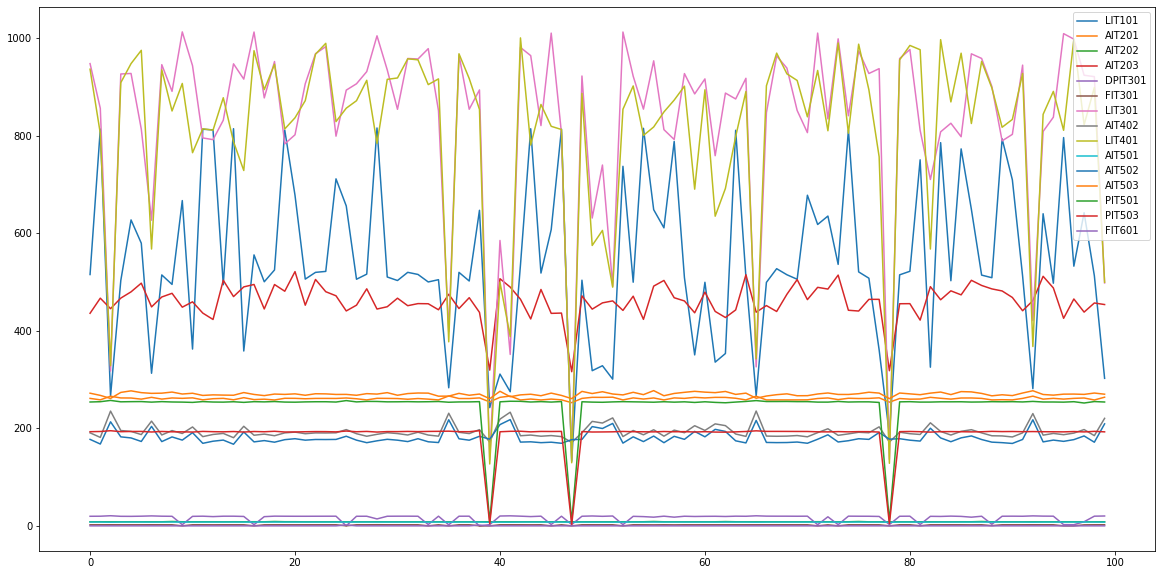

In [ ]:
dates = np.arange(100)
df2 = pd.DataFrame(scalar.inverse_transform(pred[0].cpu().numpy()), index=dates, columns=numericalVariable_list)
df2
df2.plot(figsize = (20,10))

In [ ]:
df2

,LIT101,AIT201,AIT202,AIT203,DPIT301,FIT301,LIT301,AIT402,LIT401,AIT501,AIT502,AIT503,PIT501,PIT503,FIT601
0,515.287781,261.339691,8.325732,435.831848,19.642801,2.200954,947.758911,190.736496,936.314087,7.839945,177.306854,272.012970,253.942368,193.048050,-0.001423
1,813.567627,258.388733,8.435867,466.823273,19.768526,2.208519,856.045532,181.354294,804.527100,7.856366,167.772415,267.511292,254.538788,193.479355,0.000552
2,266.496765,265.740265,8.271501,445.279297,20.748806,2.237013,317.316833,235.265610,328.430084,7.553905,213.342865,261.242737,257.169617,195.062210,0.005157
3,502.945343,262.266571,8.356423,466.949036,19.579443,2.209970,926.506409,195.460983,908.746460,7.859129,182.464828,273.591614,254.314743,193.077545,-0.001982
4,627.279846,262.120544,8.429292,479.788635,19.478472,2.200944,927.542297,193.600555,947.752319,7.863224,180.269424,276.806488,254.640594,193.508438,0.000096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,796.083557,259.887482,8.413404,425.564606,2.464039,0.008088,1009.225830,186.893448,810.993896,7.843843,173.253128,270.021973,253.653427,192.711075,-0.003451
96,532.407959,261.382629,8.338042,465.146240,2.346391,0.012375,997.936523,190.194855,997.843811,7.837512,176.805893,270.184784,254.557281,193.331848,-0.002029
97,642.011169,262.151459,8.379431,438.255157,8.450608,2.056892,923.923645,197.445389,822.269592,7.860622,184.338898,269.549377,251.859818,192.615814,0.013951
98,512.889771,258.078949,8.345712,456.954437,19.835415,2.207893,921.024536,184.958237,898.805969,7.845982,171.491699,272.307281,254.845383,193.745148,-0.000924
